In [1]:
import polars as pl
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from src.util.constants import DATA_PATH, META_MODEL_PERFORMANCE
from src.util.common import load_from_pickle, mean_grouped_spearman_correlation

In [2]:
# customise Matplotlib and Seaborn plots
plt.rc('axes.spines', right=False, top=False)  # hide top and right spine
plt.rc('axes', grid=True, linewidth=.5)  # activate grid and slim axis lines
plt.rc('xtick.major', width=.5)  # slim x-ticks
plt.rc('ytick.major', width=.5)  # slim y-ticks
plt.rc('grid', alpha=.8, linewidth=.5)  # slim, transparent grid

In [3]:
selected_features = load_from_pickle(DATA_PATH / 'results/selected_features.pkl')
required_columns = ['era', 'target'] + selected_features

df_validate_list = []

for fold in range(2):
    df_validate_fold = pl.read_parquet(f"{DATA_PATH}/folds/df_validate_{fold}.parquet")
    df_validate_fold = df_validate_fold.select(required_columns)
    df_validate_list.append(df_validate_fold)
    del df_validate_fold

df_meta_model = pl.read_parquet(f'{DATA_PATH}/folds/df_meta_model.parquet')
df_meta_model = df_meta_model.select(required_columns + ['numerai_meta_model'])

In [4]:
def performance_approximation(df_validate_with_prediction: pl.DataFrame, df_meta_model_with_prediction: pl.DataFrame, fold: int) -> tuple[float, float, float, float]:
    corr = mean_grouped_spearman_correlation(
        df_validate_with_prediction['prediction_linearised'],
        df_validate_with_prediction['target'],
        df_validate_with_prediction['era']
    )
    corr_w_mm = df_meta_model_with_prediction.select(
        pl.corr("prediction_linearised", "numerai_meta_model", method="spearman")
        .over('era', mapping_strategy='explode')
    ).mean().item()

    mmc_approximation = corr - corr_w_mm * META_MODEL_PERFORMANCE[fold]
    performance = .5 * corr + 2 * mmc_approximation

    return performance, corr, corr_w_mm, mmc_approximation

In [5]:
def get_linear_component(df: pl.DataFrame) -> pl.Series:
    X = df[selected_features].to_numpy()
    y = df['prediction'].to_numpy()
    X = np.hstack([np.ones((X.shape[0], 1)), X])

    beta_hat = np.linalg.solve(X.T @ X, X.T @ y)

    return pl.Series(X @ beta_hat)

In [6]:
df_result = pl.DataFrame()
eras_meta_model = df_meta_model['era'].unique(maintain_order=True).to_list()

for index in range(20):
    for fold in range(2):
        model = lgb.Booster(model_file=f"{DATA_PATH}/models/lgb/lgb_model_{index}_{fold}.txt")

        df_validate_with_prediction = df_validate_list[fold].with_columns(
            prediction=pl.Series(model.predict(df_validate_list[fold][selected_features].to_numpy()))
        )
        df_meta_model_with_prediction = df_meta_model.with_columns(
            prediction=pl.Series(model.predict(df_meta_model[selected_features].to_numpy()))
        )
        print(f"{datetime.now().strftime("%H:%M:%S")} . . . Model {index} for fold {fold} loaded. Forecasts made.")

        linear_component_validate = pl.Series(dtype=pl.Float64)
        linear_component_meta_model = pl.Series(dtype=pl.Float64)

        # computing the linear component vectorised via Polars structs leads to extremely slow performance

        eras_val = df_validate_with_prediction['era'].unique(maintain_order=True).to_list()
        for era in eras_val:
            df_era = df_validate_with_prediction.filter(pl.col('era') == era)[selected_features + ["prediction"]]
            linear_component_validate.extend(get_linear_component(df_era))

        for era in eras_meta_model:
            df_era = df_meta_model_with_prediction.filter(pl.col('era') == era)[selected_features + ["prediction"]]
            linear_component_meta_model.extend(get_linear_component(df_era))

        df_validate_with_prediction = df_validate_with_prediction.with_columns(
            linear_component=linear_component_validate
        )
        df_meta_model_with_prediction = df_meta_model_with_prediction.with_columns(
            linear_component=linear_component_meta_model
        )
        print(f"{datetime.now().strftime("%H:%M:%S")} . . . Linear components calculated.")

        for multiplier in [x / 10 for x in range(-10, 11)]:
            df_validate_with_prediction = df_validate_with_prediction.with_columns(
                prediction_linearised=pl.col('prediction').add(pl.col('linear_component').mul(multiplier))
            )
            df_meta_model_with_prediction = df_meta_model_with_prediction.with_columns(
                prediction_linearised=pl.col('prediction').add(pl.col('linear_component').mul(multiplier))
            )

            performance, corr, corr_w_mm, mmc_approximation = performance_approximation(df_validate_with_prediction, df_meta_model_with_prediction, fold)

            df_result = df_result.vstack(pl.DataFrame({
                'model': index,
                'fold': fold,
                'multiplier': multiplier,
                'performance': performance,
                'corr': corr,
                'corr_w_mm': corr_w_mm,
                'mmc_approximation': mmc_approximation
            }))

        print(f"{datetime.now().strftime("%H:%M:%S")} . . . Neutralisation tested.")

10:26:48 . . . Model 0 for fold 0 loaded. Forecasts made.
10:26:49 . . . Linear components calculated.
10:26:53 . . . Neutralisation tested.
10:27:21 . . . Model 0 for fold 1 loaded. Forecasts made.
10:27:22 . . . Linear components calculated.
10:27:26 . . . Neutralisation tested.
10:28:13 . . . Model 1 for fold 0 loaded. Forecasts made.
10:28:14 . . . Linear components calculated.
10:28:17 . . . Neutralisation tested.
10:29:05 . . . Model 1 for fold 1 loaded. Forecasts made.
10:29:06 . . . Linear components calculated.
10:29:09 . . . Neutralisation tested.
10:30:02 . . . Model 2 for fold 0 loaded. Forecasts made.
10:30:03 . . . Linear components calculated.
10:30:06 . . . Neutralisation tested.
10:30:57 . . . Model 2 for fold 1 loaded. Forecasts made.
10:30:58 . . . Linear components calculated.
10:31:01 . . . Neutralisation tested.
10:32:00 . . . Model 3 for fold 0 loaded. Forecasts made.
10:32:02 . . . Linear components calculated.
10:32:05 . . . Neutralisation tested.
10:33:04 . . 

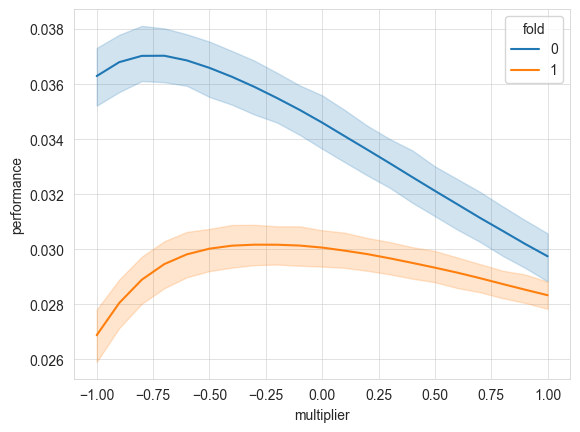

In [8]:
sns.lineplot(data=df_result, x='multiplier', y='performance', hue='fold')
plt.show()

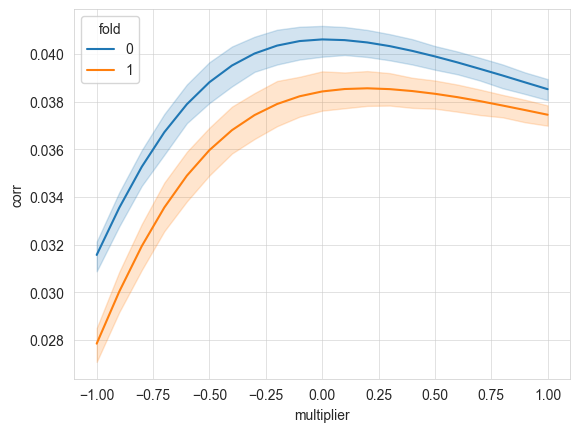

In [9]:
sns.lineplot(data=df_result, x='multiplier', y='corr', hue='fold')
plt.show()

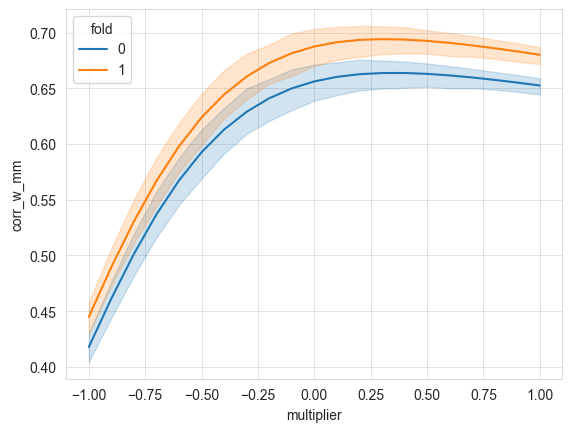

In [10]:
sns.lineplot(data=df_result, x='multiplier', y='corr_w_mm', hue='fold')
plt.show()

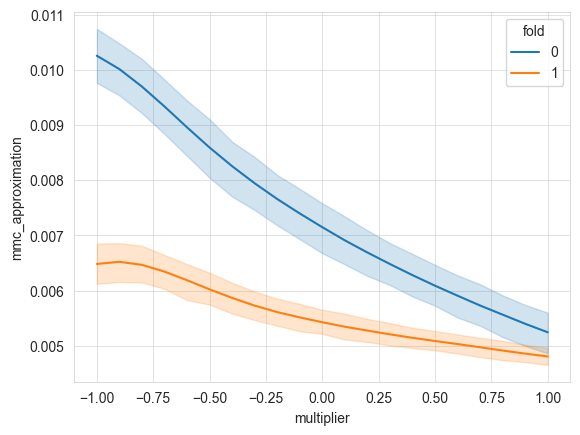

In [11]:
sns.lineplot(data=df_result, x='multiplier', y='mmc_approximation', hue='fold')
plt.show()

I will use multiplier $-.5$, or something close to it (tbd).